# Introduction

Project Group 8:

- Alicia Núñez Alcover
- David Rombach
- Tudor Nicolae Mateiu

The purpose of this project is to analyze the evolution in COVID-19 cases and deaths per country and how the number of vaccinations have affected the amount of deaths and cases.

# (0) Libraries and Imports

In this project we mainly make use of the `pandas` and `numpy` libraries for data handling.

Additionally, we employ `matplotlib` and `seaborn` for more simplistic plotting, and the `plotly` library for more user interactive plots. If you don't have `seaborn` and `plotly`, please uncomment the first code block to install the libraries.

Finally, we need the `datetime` library for needed conversions and handlings of dates.

In [1]:
# Uncomment these lines if you don't have plotly and seaborn installed
#!pip install seaborn
#!pip install plotly
# ---------------------------------------------
# If you're using conda, uncomment these lines:
# conda install -c anaconda seaborn
# conda install -c plotly plotly


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.lines import Line2D
from datetime import datetime

sns.set_theme(style="dark")
pd.options.mode.chained_assignment = None 

# (1) Loading the data

The main dataset we are using is ECDC Covid-19 data [1] provided in the project's PDF. It is loaded in the dataframe variable ``` covid_data ```.

The secondary dataset we are using is Covid-19 World Vaccination Progress [2] from Kaggle. We load this dataset in the dataframe variable ``` vaccination_data ```.

[1] ECDC Covid-19 data (2020). Available from: https://opendata.ecdc.europa.eu/covid19/nationalcasedeath/ [Accessed on 14
March 2022].

[2] Gabriel Preda (2021) COVID-19 World Vaccination Progress. Available from: https://www.kaggle.com/gpreda/covid-world-vaccination-progress [Accessed on 14 March 2022].

In [3]:
####################################
#### IMPORTANT DATA INFORMATION ####

# If opening in Google Colaboratory, simply upload the two '.csv' files in the default Files folder
# and uncomment the lines below:
covid_data = pd.read_csv('covid_dataset.csv', delimiter = ',', header = 0)
vaccination_data = pd.read_csv('vaccinations_dataset.csv', delimiter = ',', header = 0)

# If opening in local Jupyter Notebook, you can just leave the data in the same folder as the notebook
# and uncomment the lines below:
#covid_data = pd.read_csv('covid_dataset.csv', delimiter = ',', header = 0)
#vaccination_data = pd.read_csv('vaccinations_dataset.csv', delimiter = ',', header = 0)

---

# (2) Cleaning the data prior to combination

We first remove unwanted columns from each of the datasets, as there are many columns that will not be used because they are either useless to the project's scope or have mainly NaN values.

For the first dataset, the Covid dataset, we only leave ``` country ```, ``` population ```, ``` indicator ```, ``` year_week ```, ``` cumulative_count ```.

For the second dataset, the vaccinations dataset, we leave ``` country ```, ``` date ```, ``` daily_vaccinations ```.

By having both datasets' key value be the country, we can achieve the correct union of the two datasets. The following information must also be noted for the datasets:

1. We left the ``` population ``` column for the Covid dataset, in case we wanted to carry out visualizations in regard to population ratios or data per 100k people.
2. For the Covid dataset, columns ``` indicator ```, ``` year_week ``` and ``` cumulative_count ``` respectively indicate if the row value is either an infection case or a death, in what week of the year this data is obtained from and what the value of cases/deaths for that week is.
3. For the vaccination dataset, columns ``` date ``` and ``` daily_vaccinations ``` respectively indicate the date of the year the data is obtained and the amount of vaccinations in that date. As the ``` date ``` column is in YYYY-MM-DD format, we must later have to convert these dates to week of the year in order to be usable with the Covid dataset. As a result, we must also aggregate the vaccinations for the same week of the year.


In [4]:
covid_data = covid_data.drop(columns=['country_code', 'rate_14_day', 'continent',
                              'source', 'note', 'weekly_count'])

vaccination_data = vaccination_data.drop(columns=['iso_code', 'vaccines', 'source_name', 'source_website',
                                'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred', 
                                'daily_vaccinations_per_million','total_vaccinations_per_hundred', 
                                'daily_vaccinations_raw', 'total_vaccinations', 'people_vaccinated', 
                                'people_fully_vaccinated'])

## (2.1) Samples of each dataset

In [5]:
covid_data.sample(n=5)

,country,population,indicator,year_week,cumulative_count
14092,Estonia,1328976,deaths,2022-04,1930
5233,Bermuda,62273,cases,2020-23,141
35191,Romania,19328838,cases,2020-46,353970
31914,Northern Mariana Islands,57557,cases,2021-31,206
6146,Bosnia And Herzegovina,3280815,deaths,2020-20,133


In [6]:
vaccination_data.sample(n=5)

,country,date,daily_vaccinations
62593,Saint Vincent and the Grenadines,2021-12-07,290.0
64774,Senegal,2021-11-08,1720.0
50360,Myanmar,2021-02-21,12222.0
33374,Iceland,2021-11-13,1184.0
64233,Scotland,2021-05-29,45613.0


---

## (2.2) Removing rows containing NaN values
We use the pandas command ```DataFrame.dropna()``` to delete rows that contain in any column a NaN (Not a Number) value. In the following code, this function is applied to the main dataset ```covid_data``` 
and the additionaly dataset ```vaccination_data```.

In [7]:
# check and remove if necessary NaN values of covid_data
covid_has_nans = covid_data.isnull().values.any()
print("Does `covid_data` dataset contain any NaN value? {}".format(covid_has_nans))
if covid_has_nans:
  covid_data = covid_data.dropna()
  print("Removing NaN values of covid_data dataset...")
else:
  print("Skipping removing NaN values...")

Does `covid_data` dataset contain any NaN value? False
Skipping removing NaN values...


In [8]:
# check and remove if necessary NaN values of vaccination_data
vaccination_has_nans = vaccination_data.isnull().values.any()
print("Does `vaccination_data` dataset contain any null value? {}".format(vaccination_has_nans))
if vaccination_has_nans:
  vaccination_data = vaccination_data.dropna()
  print("Removing NaN values of covid_data dataset...")

Does `vaccination_data` dataset contain any null value? True
Removing NaN values of covid_data dataset...


## (2.3) Weekly data conversion

In order to be able to use the vaccination dataset with the Covid dataset, we need to convert the dates from the vaccination dataset into the same weekly format as the Covid dataset.

The Covid dataset's date format is comprised of a four digit number indicating the year and a two digit number indicating the week's number in that year: YYYY-WW. E.g.: 2021-08 indicates week 8 from the year 2021.

To do the conversion from the vaccination dataset, we iterate on it's rows and convert the daily dates into the format mentioned above using functions from the ``` datetime ``` library. The conversion is carried out in the ``` get_week_num ``` function.


In [9]:
def get_week_num(country_row):
    # Use strptime to convert the string to date object
    date = datetime.strptime(country_row['date'], '%Y-%m-%d')

    # Use strftime to convert the date to the wanted YYYY-WW format
    return datetime.strftime(date, '%G-%V')

In [10]:
vaccination_data_weekly_data = [] # List that will hold the data with converted dates

for _, country_row in vaccination_data.iterrows():
        
        week_num = get_week_num(country_row)
        
        # Append [country, week_number, daily_vaccinations]
        vaccination_data_weekly_data.append([country_row['country'], week_num, country_row['daily_vaccinations']])

# Convert the data list into a dataframe
vaccination_data_weekly = pd.DataFrame(vaccination_data_weekly_data, columns = ['country', 'year_week', 'vaccine_count'])

vaccination_data_weekly.head()

,country,year_week,vaccine_count
0,Afghanistan,2021-08,1367.0
1,Afghanistan,2021-08,1367.0
2,Afghanistan,2021-08,1367.0
3,Afghanistan,2021-08,1367.0
4,Afghanistan,2021-08,1367.0


After the successful date conversion to weeks of the year, we are justifiably left with a dataframe where multiple rows have the same week number and different vaccine count. Thus, in order to obtain the weekly vaccine counts, we use the `groupby` function to group the rows by `country` and `year_week` and then `sum` the `vaccine_count`.

In [11]:
vaccination_data_weekly = pd.DataFrame(vaccination_data_weekly.groupby(['country', 'year_week'])['vaccine_count'].sum()).reset_index()
vaccination_data_weekly.sample(n=5)

,country,year_week,vaccine_count
6045,Lesotho,2021-31,7196.0
1598,Brunei,2021-52,43211.0
8396,Peru,2021-11,230489.0
1822,Cameroon,2021-51,16767.0
2281,Comoros,2021-23,793.0


## (2.4) Pivot covid data

The covid dataset contains a column called `indicator` which specificies if the value in `cumulative_count` is related to cases or deaths. We wish to change this structure and have two independent columns called `cases` and `deaths` containing the values that are in `cumulative_count`, so we can create plots easily.
To do so, we use the function `pivot_table` from `pandas`, which creates a spreadsheet-style pivot table in a form of a DataFrame.
Finally, `to_records` is used to convert the pivot table to a NumPy record array and we create a `DataFrame` again.

In [12]:
# Examples of indicator `cases` and `deaths`
covid_data.loc[(covid_data['indicator'] == 'cases')].head()

,country,population,indicator,year_week,cumulative_count
0,Afghanistan,38928341,cases,2020-01,0
1,Afghanistan,38928341,cases,2020-02,0
2,Afghanistan,38928341,cases,2020-03,0
3,Afghanistan,38928341,cases,2020-04,0
4,Afghanistan,38928341,cases,2020-05,0


In [13]:
covid_data.loc[(covid_data['indicator'] == 'deaths')].head()

,country,population,indicator,year_week,cumulative_count
113,Afghanistan,38928341,deaths,2020-01,0
114,Afghanistan,38928341,deaths,2020-02,0
115,Afghanistan,38928341,deaths,2020-03,0
116,Afghanistan,38928341,deaths,2020-04,0
117,Afghanistan,38928341,deaths,2020-05,0


In [14]:
# Pivot table
covid_data = pd.DataFrame(covid_data.pivot_table(values='cumulative_count', 
                          index=['country', 'year_week', 'population'], columns='indicator').to_records())

covid_data.sample(n=5)

,country,year_week,population,cases,deaths
14007,Mexico,2021-09,128932753,2130477,190923
3814,Burundi,2021-21,11890781,4754,6
18013,Saint Lucia,2020-20,183629,18,0
16302,Oman,2021-01,5106622,130780,1508
12804,Liechtenstein,2022-05,38747,9765,73


## (2.5) Cumulative values to weekly values

Moreover, the new columns `cases` and `deaths` from the covid dataset contain a cumulative count, but we are interested in the weekly values so it can be compared with the vaccination data. Therefore, we compute the difference between a row and its previous row to obtain the corresponding weekly value, using the function `diff()` from pandas.

In [15]:
covid_data['cases'] = covid_data.groupby('country')['cases'].diff()
covid_data['deaths'] = covid_data.groupby('country')['deaths'].diff()

---

# (3) Combining the data
Now, we are interested in combining both datasets. To do so, we use the function `merge()` from pandas. This merge by default is a inner join, which consists on the intersection of keys from both frames using the columns `country` and `year_week` to join on.

In [16]:
merged_data = pd.merge(covid_data, vaccination_data_weekly, on = ['country', 'year_week'])

# Rename the columns to avoid confusions
merged_data = merged_data.rename(columns={"cases": "weekly_cases", "deaths": "weekly_deaths", 
                                          "vaccine_count": "weekly_vaccines"})
merged_data.head()

,country,year_week,population,weekly_cases,weekly_deaths,weekly_vaccines
0,Afghanistan,2021-08,38928341,245.0,19.0,8202.0
1,Afghanistan,2021-09,38928341,117.0,5.0,15549.0
2,Afghanistan,2021-10,38928341,119.0,9.0,20034.0
3,Afghanistan,2021-11,38928341,182.0,6.0,20331.0
4,Afghanistan,2021-12,38928341,117.0,4.0,20980.0


## (3.1) Choosing countries and weeks

Now, we wish to limit our analysis to a set of countries, which will be the countries of Europe. However, our new merged dataset poses a problem: there are many countries that don't share the same weeks. To do so, we will establish a date range we are interested in, remove rows that are before and after this range, and remove all the occurences of a country that have missing weeks within the established date range.

We have chosen a date range between 2021-01-04 and 2022-05-04. This date range
will be in a year-week format.

In [17]:
# Generate a weekly fixed date range between 2021-01-04 and 2022-05-04 
date_range = pd.date_range(start="2021-01-04", end="2022-05-04", freq='W-SUN').tolist()

# Convert the date range in the format year-week in ISO format
date_range = [datetime.strftime(week, '%G-%V') for week in date_range]
print("The date range is: {}".format(date_range))

The date range is: ['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2021-13', '2021-14', '2021-15', '2021-16', '2021-17', '2021-18', '2021-19', '2021-20', '2021-21', '2021-22', '2021-23', '2021-24', '2021-25', '2021-26', '2021-27', '2021-28', '2021-29', '2021-30', '2021-31', '2021-32', '2021-33', '2021-34', '2021-35', '2021-36', '2021-37', '2021-38', '2021-39', '2021-40', '2021-41', '2021-42', '2021-43', '2021-44', '2021-45', '2021-46', '2021-47', '2021-48', '2021-49', '2021-50', '2021-51', '2021-52', '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2022-13', '2022-14', '2022-15', '2022-16', '2022-17']


In [18]:
# List of countries (Europe) we are interested in
europe_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']

# Filter countries that are not in Europe
europe_data = merged_data[merged_data['country'].isin(europe_countries)]

# We only want countries with the same weeks.
countries_to_remove = []
for idx, row in europe_data.iterrows():
    # If the data is just before 2021-01, remove row
    if row['year_week'] < date_range[0]:
      europe_data.drop(idx, inplace=True)
    # If the data is just after 2022-17, remove row
    elif row['year_week'] > date_range[-1]:
      europe_data.drop(idx, inplace=True)
    # If there's a week missing within, remove rows of entire country
    elif row['year_week'] not in date_range:
      countries_to_remove.append(row['country'])

# Remove the countries that have missing weeks within our selected range of data
for i in countries_to_remove:
  europe_data = europe_data[europe_data['country'].apply(lambda x: i not in x)]

# (4) Analyzing the data

In the following sections basic statistical properties of the combined data are calculated. While the distributions and standard deviations are calculated per 100.000 population to allow better comperability between large and small countries the section calculating statistical mean values does not take the countries population difference into consideration. 

We decided to show the statistical properties mean and standard deviation as sorted bar chart because it allows the reader to faster see the general trend and difference between values whereas a table would require more reading time.

In [19]:
europe_data["weekly_cases_per100k"] =  (europe_data["weekly_cases"] / europe_data["population"]) * 100000
europe_data["weekly_deaths_per100k"] = (europe_data["weekly_deaths"] / europe_data["population"]) * 100000
europe_data["weekly_vaccines_per100k"] = (europe_data["weekly_vaccines"] / europe_data["population"]) * 100000

## (4.1) Distribution of weekly cases per 100.000 population in Europe

This chapter shows the distribution of weekly cases per 100.000 population per county in Europe. We can identify that in the time measured, Lithuania had in one week more than 2000 more cases per 100.000 compared to all other counties included in this comparision. This property can be seen from its highest outlier at 8000. In addtion, Lithuania has followed by Czechia and Slovakia the largest maximum case rate. Furthermore we can identify in this comparison that Finland had the lowest median and lowest maximum in weekly new cases. The achieved minimum cases per 100.000 population is in all countries very close to 0 or even 0.  

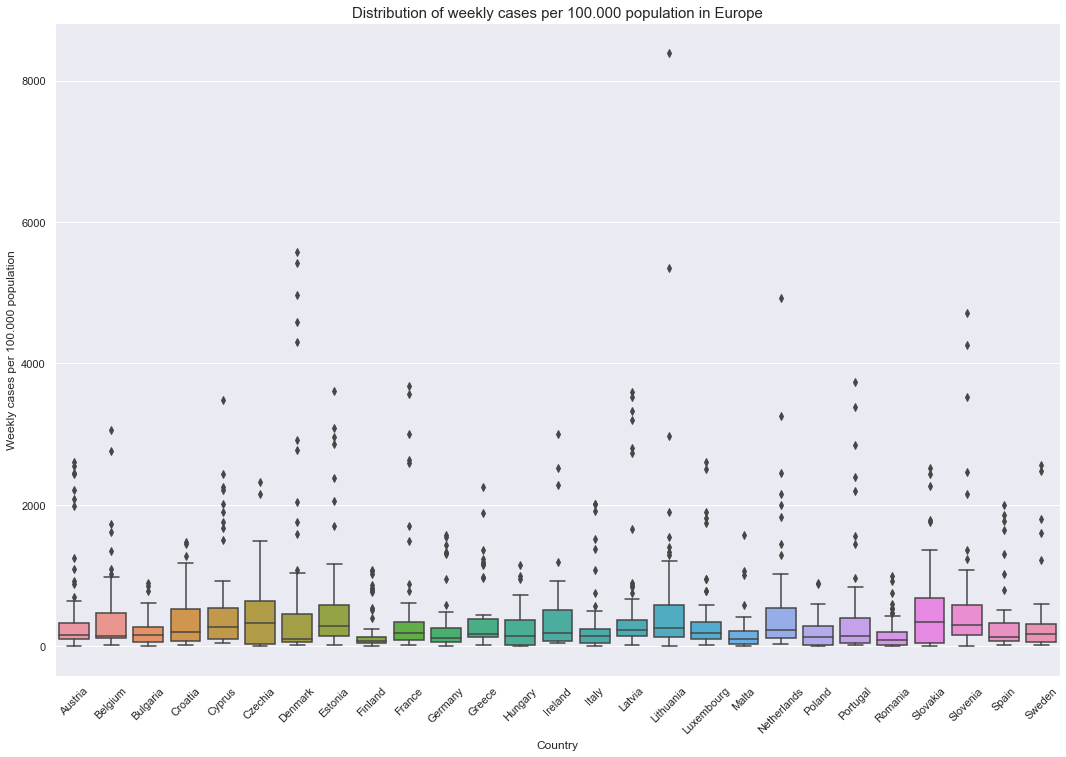

In [20]:
plt.figure(figsize=(18,12))
ax = sns.boxplot(x="country", y="weekly_cases_per100k", data=europe_data)
ax.set(xlabel="Country", ylabel="Weekly cases per 100.000 population")
ax.set_title("Distribution of weekly cases per 100.000 population in Europe", size=15)
ax.tick_params(axis='x', labelrotation=45)
plt.grid(axis='y')
plt.show()

## (4.2) Distribution of weekly deaths per 100.000 population in Europe

In the following chapter we can show the distribution of weekly deaths per 100.000 population per county in Europe. Clearly to see is that Hungary had with approximately 19 deaths per 100.000 the highest death rate. Czechia follows after Bulgaria with the 3rd highest death rate in a week when outliers are not taken into consideration. Additionally, Bulgaria has the highest median death rate of about 7 deaths per 100.000 in the measured time period from week 1 2020 to week 10 in 2022. The lowest median death rate per 100.000 was achieved by Denmark, whereas Finland has the smallest maximum and smallest difference between their first and thrid percentile. This tells us that in Finland was a constant low death rate.

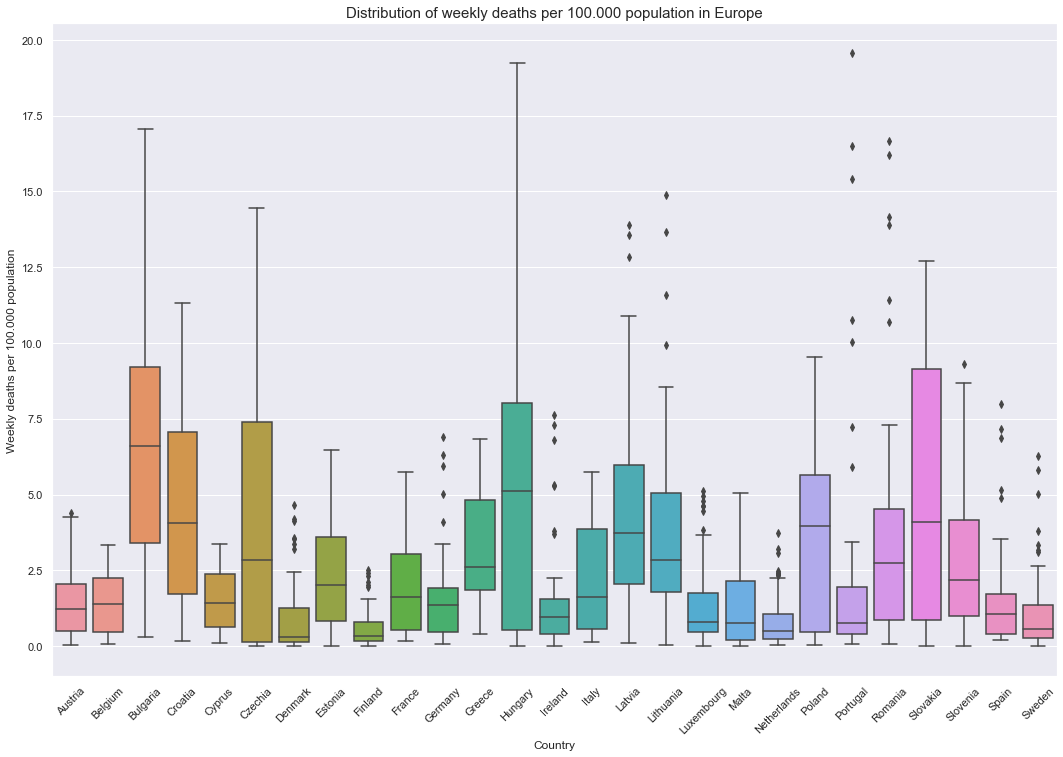

In [21]:
plt.figure(figsize=(18,12))
ax = sns.boxplot(x="country", y="weekly_deaths_per100k", data=europe_data)
ax.set(xlabel="Country", ylabel="Weekly deaths per 100.000 population")
ax.set_title("Distribution of weekly deaths per 100.000 population in Europe", size=15)
ax.tick_params(axis='x', labelrotation=45)
plt.grid(axis='y')
plt.show()

## (4.3) Distribution of weekly vaccines per 100.000 population in Europe

In this chapter we show the distribution of weekly vaccines per 100.000 population in Europe. In the figure you can see that Bulgaria has by far the lowest maximum number of vaccines per week of about 2500 per 100.000 population. Compared to this, Denmark was able to achieve a maximum number of vaccines per week of close to 12000 vaccines per week per 100.000. The highest median vaccination rate per week was achieved by Malta, followed by Portugal, Sweden and Finland.  

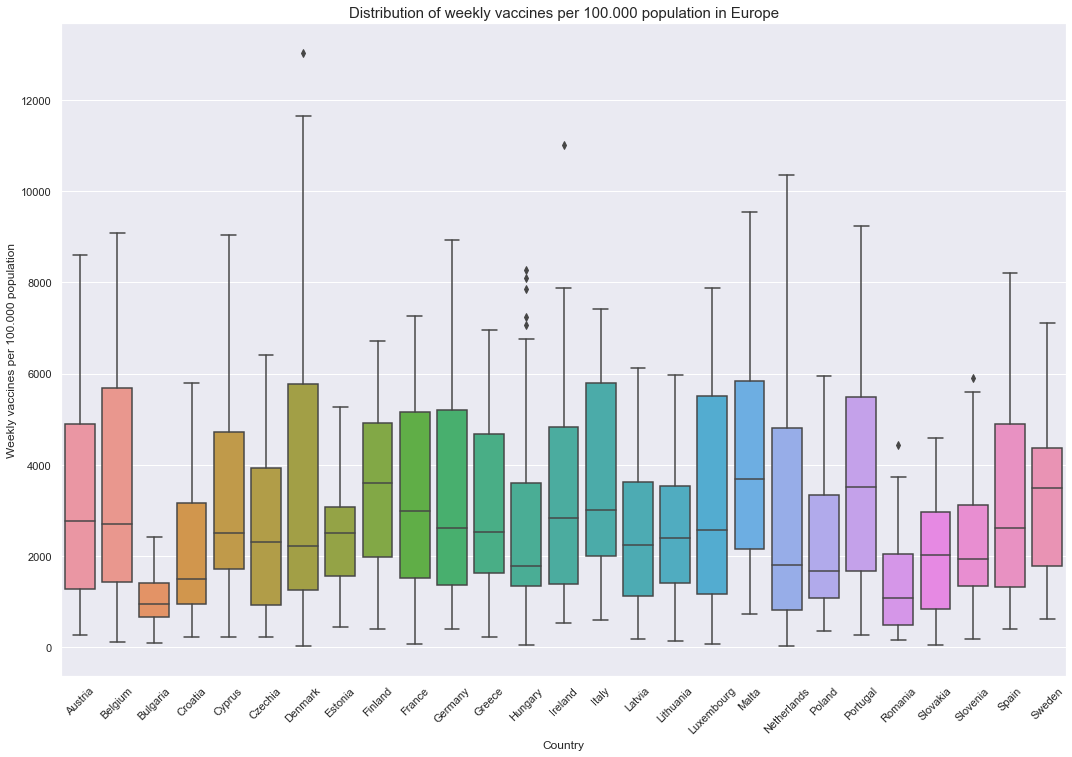

In [22]:
plt.figure(figsize=(18,12))
ax = sns.boxplot(x="country", y="weekly_vaccines_per100k", data=europe_data)
ax.set(xlabel="Country", ylabel="Weekly vaccines per 100.000 population")
ax.set_title("Distribution of weekly vaccines per 100.000 population in Europe", size=15)
ax.tick_params(axis='x', labelrotation=45)
plt.grid(axis='y') 
plt.show()

## (4.4) Mean of weekly cases per country in Europe

In the following graph we are presenting statistical mean values of weekly cases per country in Europe. We can identify that the size of a country in terms of population influences the weekly cases mean values. We see that France, Germany, Italy and Spain with populations close to and over 50 million people are having the largest weekly cases mean values. But to be noticed is that Germany has a more than 10 million people larger population than France but France is still leading the ranking with a mean 140000 cases larger than Germany. 

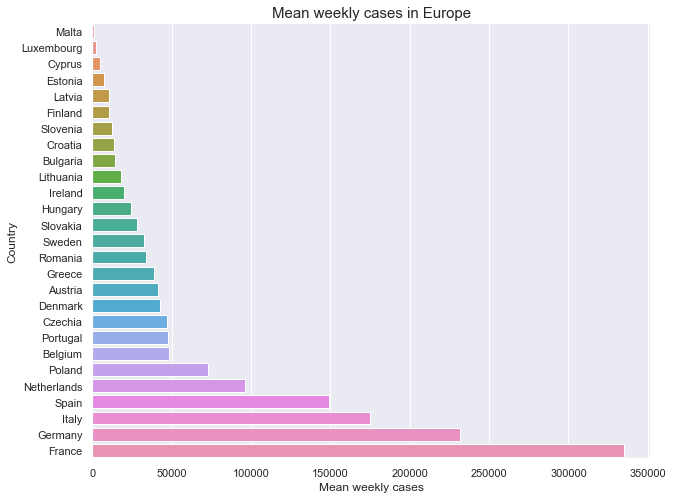

In [23]:
# Mean weekly cases by country
plt.figure(figsize=(10,8))
sorted_cases = europe_data.groupby('country').mean().sort_values(by=['weekly_cases'])
ax = sns.barplot(x = sorted_cases['weekly_cases'], y=sorted_cases.index , orient='h')
ax.set(xlabel="Mean weekly cases", ylabel="Country")
ax.set_title("Mean weekly cases in Europe", size=15)
plt.grid(axis='x')
plt.show()

## (4.5) Mean of weekly deaths per country in Europe

In the following graph we present the mean of weekly death per country in Europe. That the absolute population of a country is not the only factor to reach the highest value of the mean value of a weekly covid property is seen here. Poland which is about half the size in terms of population compared to Germany and France achieved a higher mean in weekly deaths. This statement is supported by the weekly deaths mean of Italy which is nearly the same as in France and Germany with an about 7 and 13 million people smaller population.

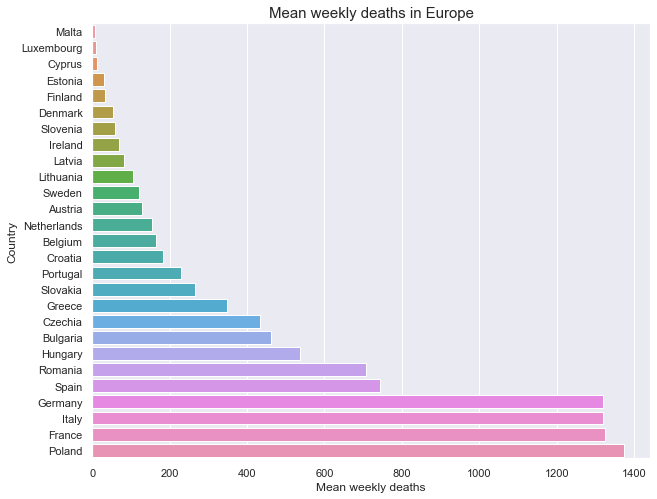

In [24]:
# Mean weekly deaths by country
plt.figure(figsize=(10,8))
sorted_deaths = europe_data.groupby('country').mean().sort_values(by=['weekly_deaths'])
ax = sns.barplot(x = sorted_deaths['weekly_deaths'], y = sorted_deaths.index)
ax.set(xlabel="Mean weekly deaths", ylabel="Country")
ax.set_title("Mean weekly deaths in Europe", size=15)
plt.grid(axis='x')
plt.show()

## (4.6) Mean of weekly vaccines per country in Europe

In this chapter we show the mean value of weekly vaccines per country in Europe. For the mean of weekly vaccinations, we can see that the size of the country in terms of population has a positive effect in reaching a high absolute mean value. But the absolute values give only limited insight into which country has in fact vaccinated a large or small amount of their population, since small countries like Luxembourg or Malta have a by far smaller population not allowing them to reach average weekly vaccine values even close to the ones calculated by big countries like Spain, Italy, France and Germany.

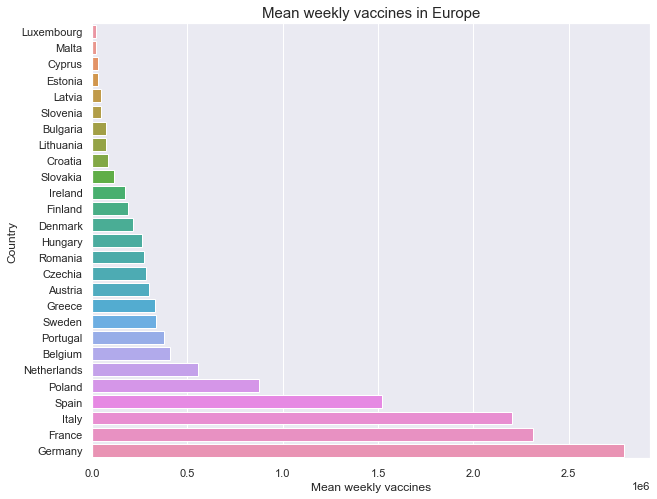

In [25]:
# Mean weekly cases by country
plt.figure(figsize=(10,8))
sorted_vaccines = europe_data.groupby('country').mean().sort_values(by=['weekly_vaccines'])
ax = sns.barplot(x = sorted_vaccines['weekly_vaccines'], y=sorted_vaccines.index , orient='h')
ax.set(xlabel="Mean weekly vaccines", ylabel="Country")
ax.set_title("Mean weekly vaccines in Europe", size=15)
plt.grid(axis='x')
plt.show()

## (4.7) Standard Deviation of weekly cases per country in Europe

The standard deviation shows us how much the weekly values deviate from the calculated mean. Thus, it represents the volatility of the recorded values and can tell us whether Covid occurred in strong or weak waves in each country. In case of the weekly vaccines we can differentiate between countries having enough vaccines to vaccinate their population in peaks versus counties where the vaccinations took place over a longer period of time resulting in a lower standard deviation.

This chapter shows the standard deviation of weekly cases per 100.000 population per county in Europe sorted by value. We can identify that Lithuania and Denmark have the highest deviation from their mean value of more than 1200 cases per 100.000, whereas Bulgaria, Poland and Romania have a deviation of approximately 200 to 300 telling us that they are having a more steady covid case happening. 

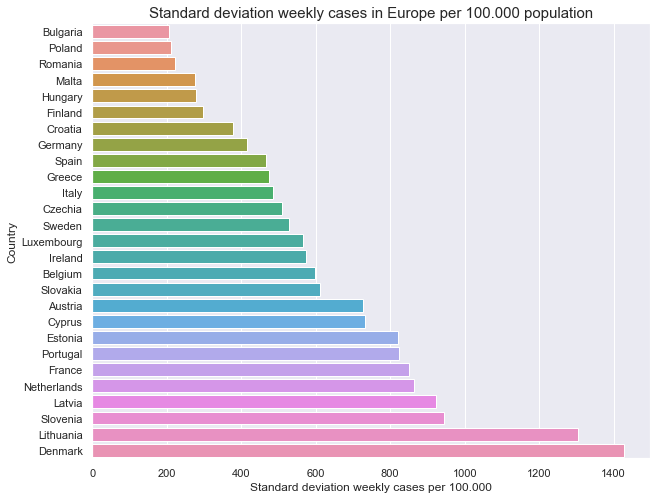

In [26]:
# Standard deviation weekly cases by country
plt.figure(figsize=(10,8))
# group dataset by country and calculate standard deviation. Additionally sorty by the given column
sorted_cases_std = europe_data.groupby('country').std().sort_values(by=['weekly_cases_per100k'])
ax = sns.barplot(x = sorted_cases_std['weekly_cases_per100k'], y = sorted_cases_std.index)
# include lable and title
ax.set(xlabel="Standard deviation weekly cases per 100.000", ylabel="Country")
ax.set_title("Standard deviation weekly cases in Europe per 100.000 population", size=15)
plt.grid(axis='x')
plt.show()

## (4.8) Standard Deviation of weekly deaths per country in Europe

This chapter shows the standard deviation of weekly deaths per 100.000 population  per county in Europe sorted by value. We are able to see that especially countries known for their good health care system like Finland have been able to achieve a low variation of weekly deaths from their mean. Also Denkmark which had the second highest standard deviation in weekly cases per 100.000 meaning that they had strong waves of covid cases, has been able to achieve the 6th. lowest standard deviation in weekly deaths. This allows us to infer that their health system was able to deal with its strong waves better than for example Lithuania. Lithuania is comparable to Denmark in terms of the standard deviation in weekly cases but their standard deviation in weekly deaths is approximately double as high.  

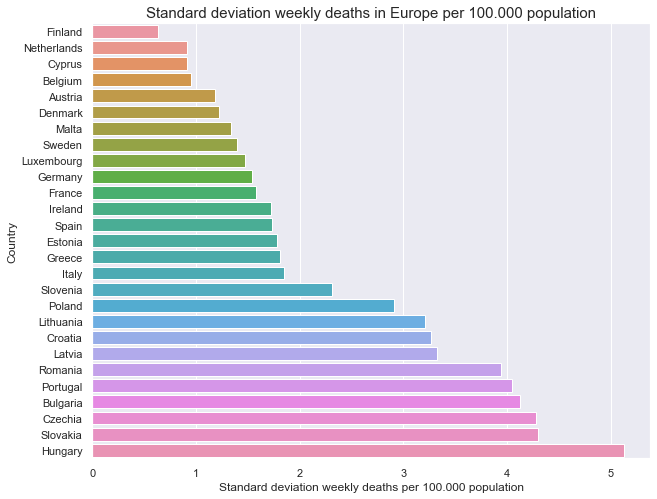

In [27]:
# Standard deviation weekly deaths by country
plt.figure(figsize=(10,8))
# group dataset by country and calculate standard deviation. Additionally sorty by the given column
sorted_deaths_std = europe_data.groupby('country').std().sort_values(by=['weekly_deaths_per100k'])
ax = sns.barplot(x = sorted_deaths_std['weekly_deaths_per100k'], y = sorted_deaths_std.index)
# include lable and title
ax.set(xlabel="Standard deviation weekly deaths per 100.000 population", ylabel="Country")
ax.set_title("Standard deviation weekly deaths in Europe per 100.000 population", size=15)
plt.grid(axis='x')
plt.show()

## (4.9) Standard Deviation of weekly vaccines per country in Europe

This chapter shows the standard deviation of weekly vaccines per 100.000 population per county in Europe sorted by value. From this figure we can see which counties had been vaccinating quick, resulting in strong peaks of vaccinations per week compared to countries that vaccinated slower in a more steady manner resulting in a lower standard deviation. Denmark and the Netherlands are from the selected counties the ones with the highest weekly vaccine variation of more than 2500 vaccines per 100.000 of their population. Bulgaria was not able to achieve strong weekly vaccine peaks, seen in their low standard deviation of only 500 vaccines per week per 100.000 of their population.

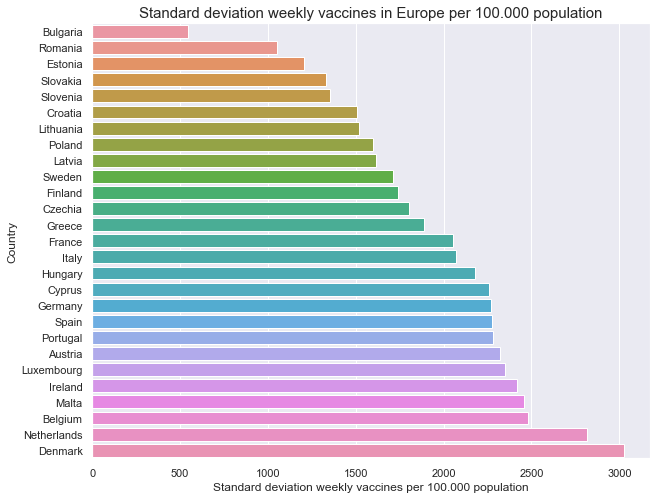

In [28]:
# Standard deviation weekly vaccines by country
plt.figure(figsize=(10,8))
# group dataset by country and calculate standard deviation. Additionally sorty by the given column
sorted_vaccines_std = europe_data.groupby('country').std().sort_values(by=['weekly_vaccines_per100k'])
ax = sns.barplot(x = sorted_vaccines_std['weekly_vaccines_per100k'], y = sorted_vaccines_std.index)
# include lable and title
ax.set(xlabel="Standard deviation weekly vaccines per 100.000 population", ylabel="Country")
ax.set_title("Standard deviation weekly vaccines in Europe per 100.000 population", size=15)
plt.grid(axis='x')
plt.show()

# (5) Visualizing and reporting results

## (5.1) Evolution of global cases, deaths and vaccinations administered with time

The first visualization we have carried out is that of a multiple timeseries plot. The first plot is an evolution of global cases and vaccines over time, and the second plot is an evolution of global deaths and vaccines over time.

A timeseries plot was chosen because the visualization aims at examining if there are interesting observations that can be extracted from how the cases and deaths evolve over time by also taking into account the amount of vaccines that are administered.

In [29]:
# Week indices to be used for the x-ticks labels
weeks_indices = list(range(0, len(date_range)-6, 4))

# Week values to be used for the x-ticks labels
weeks_chosen = [date_range[i] for i in weeks_indices]

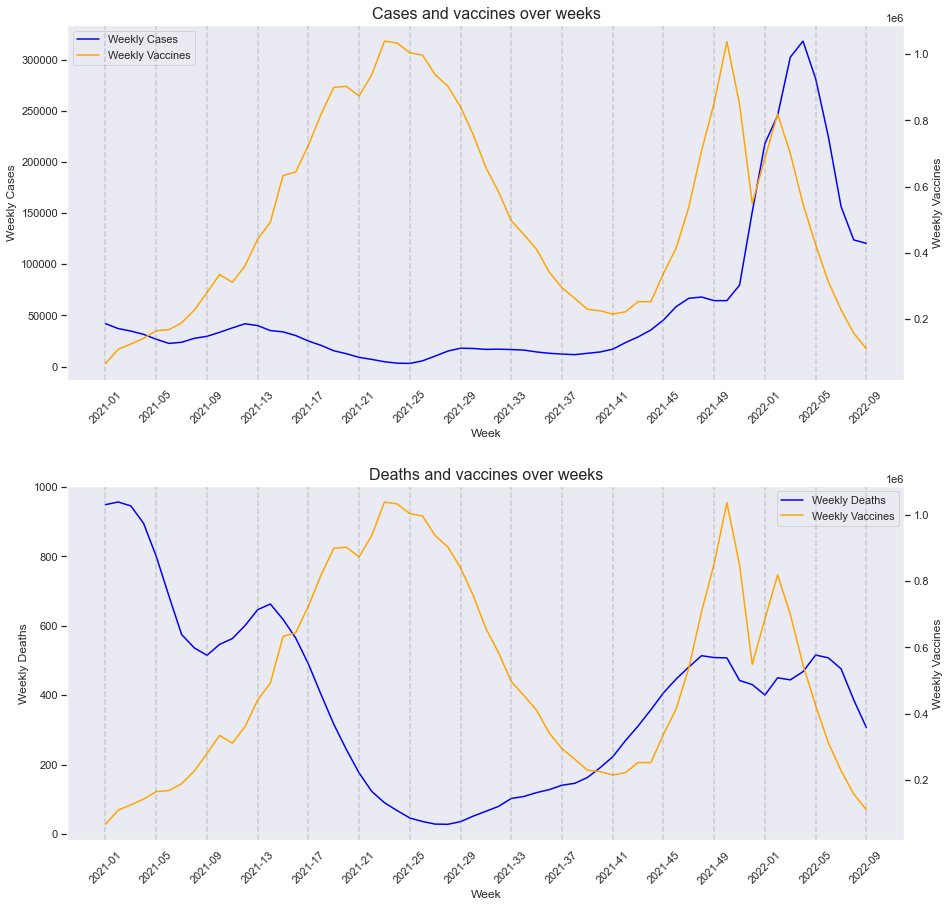

In [30]:
fig, ax = plt.subplots(2, 1)
fig.set_figheight(15)
fig.set_figwidth(15)

fig.subplots_adjust(hspace=.3)

# First plot, evolution of weekly cases (y1-axis) and weekly vaccines (y2-axis) over time (x-axis).

g = sns.lineplot(x = europe_data['year_week'], y = europe_data['weekly_cases'], color = 'blue', ci = None, ax = ax[0])
sns.lineplot(x = europe_data['year_week'], y = europe_data['weekly_vaccines'], color = 'orange', ax = g.axes.twinx(), ci = None)

# Rotate x-axis labels for better visualization
ax[0].tick_params(axis='x', labelrotation=45) 

# Set title, legend and axes labels
ax[0].set_title('Cases and vaccines over weeks', fontdict = {'fontsize' : 16})
g.legend(handles=[Line2D([], [], color='blue', label='Weekly Cases'), Line2D([], [], color='orange', label='Weekly Vaccines')])
g.axes.set_ylabel('Weekly Cases')
g.axes.set_xlabel('Week')
plt.ylabel('Weekly Vaccines')

# Set xticks intervals to every 4 weeks
plt.xticks(weeks_indices, weeks_chosen)

# Plot vertical gray dotten lines from the x-axis labels for better visualization
for week in weeks_chosen:
    plt.axvline(x = week, ls = '--', color = 'gray', alpha = 0.3)
##

# Second plot, evolution of weekly deaths (y1-axis) and weekly vaccines (y2-axis) over time (x-axis).

g = sns.lineplot(x = europe_data['year_week'], y = europe_data['weekly_deaths'], color = 'blue', ci = None, ax = ax[1])
sns.lineplot(x = europe_data['year_week'], y = europe_data['weekly_vaccines'], color = 'orange', ax = g.axes.twinx(), ci = None)

# Rotate x-axis labels for better visualization
ax[1].tick_params(axis='x', labelrotation=45)

# Set title, legend and axes labels
ax[1].set_title('Deaths and vaccines over weeks', fontdict = {'fontsize' : 16})
g.legend(handles=[Line2D([], [], color='blue', label='Weekly Deaths'), Line2D([], [], color='orange', label='Weekly Vaccines')])
g.axes.set_ylabel('Weekly Deaths')
g.axes.set_xlabel('Week')
plt.ylabel('Weekly Vaccines')

# Set xticks intervals to every 4 weeks
plt.xticks(weeks_indices, weeks_chosen)

# Plot vertical gray dotten lines from the x-axis labels for better visualization
for week in weeks_chosen:
    plt.axvline(x = week, ls = '--', color = 'gray', alpha = 0.3)
##

The plots show an inherent problem when dealing with vaccines data, in that the immunizing effect is slow and its effects are observable only after a few weeks.

1.   In the first plot, it is visible how between weeks 2021-01 and 2021-41, the new weekly cases (blue) maintain a steady and low evolution, which can be the result of the high peak in weekly vaccinations (orange) being carried out during those weeks. 

    But, as a possible consequence of the decrease in the amount of vaccines after around week 2021-25, there is a delayed effect starting in week 2021-41, where the number of cases start to grow again. This same effect can be seen after week 2022-05. Additionally, the gap in-between vaccination peaks can be due to the wait period between vaccine doses and booster shots.

2. In the second plot, we can see the same trend as weekly cases, but for the weekly amount of deaths due to Covid. The amount of deaths decreases with a delay period of a couple of weeks from when the vaccines start being administered to the population. 

    Additionally, the deaths rise again as the vaccines slow down because of the possible time required between doses, albeit they do not reach the same amount of cases as at the start of the available data.

## (5.2) Comparison of total number of deaths, cases and vaccinations per country per 100.000 population

In the following graphical visualization we are comparing the countries Finland, Germany, Italy, France, Hungary, Greece and Malta on total number of deaths, cases and vaccinations of COVID-19 in the time period Week 1 of 2020 to Week 10 of 2022. In order to make the countries comparable the values are calculated per 100.000 people of the countries population.

A bar plot was chosen because the visualization aims to show how the specified metrics deaths, cases and vaccinations differ in their order of magnitude in the selected countries. Additionally, it is easy for the viewer to find minimum and maximum values.

The function `get_population()` is used to get the population of countries passed as function argument. The population values are in the same order as countries in the passed list.

In [31]:
def get_population(countries):
  populations = []
  #iterate over given country list. 
  for country in countries:
    #append to populations list the population value of the currently iterated country
    populations.append(europe_data.loc[europe_data["country"] == country].iloc[-1,2])
  return populations

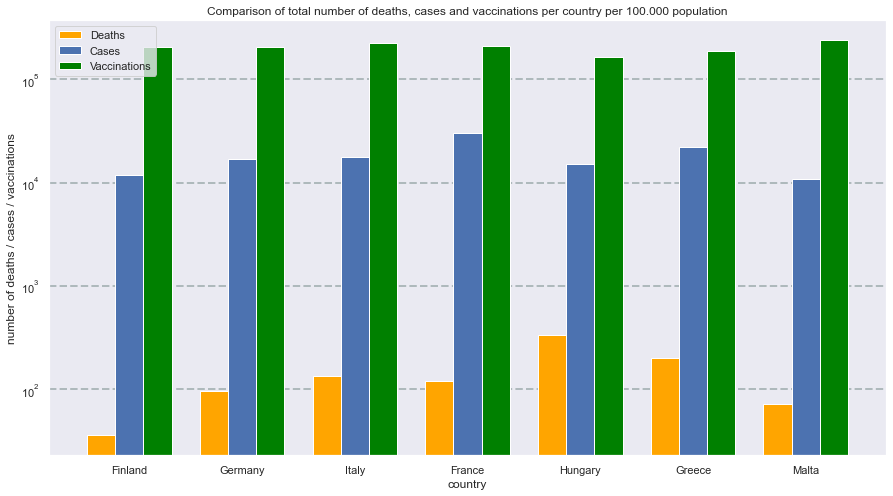

In [32]:
summed_by_country = europe_data.groupby(by=["country"]).sum()
countries = ["Finland", "Germany", "Italy", "France", "Hungary", "Greece", "Malta"]
populations = get_population(countries)
cases = summed_by_country.loc[countries,"weekly_cases"] / populations * 100000
deaths = summed_by_country.loc[countries,"weekly_deaths"] / populations * 100000
vaccinations = summed_by_country.loc[countries,"weekly_vaccines"] / populations * 100000
index = np.arange(len(countries))


# Create figure and axis #1
fig, ax1 = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

# plot bar chart on axis #1
ax1.bar(index-0.25, deaths, width=0.25, color='orange', label = 'Deaths')

# plot bar chart on axis #1
ax1.bar(index+0, cases, width=0.25, label = 'Cases') 

# plot bar chart on axis #1
ax1.bar(index+0.25, vaccinations, width=0.25, color='green', label = 'Vaccinations')

ax1.set_yscale("log")   #change y scale to logarithmic
ax1.set_ylabel('number of deaths / cases / vaccinations') #set y axis label
ax1.legend(loc="upper left")    #include legend
ax1.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.7)   #add grid

ax1.set_xticks(index)               #set x axis ticks
ax1.set_xticklabels(countries)      #set country labels for x axis
ax1.set_xlabel("country")           #set x axis label
ax1.set_title("Comparison of total number of deaths, cases and vaccinations per country per 100.000 population")    #et plot title
plt.show()

What this bar plot shows first, is that the case rates are roughtly 2 orders of magnitudes larger than the death rates in all countries, while the vaccination rates are 3 orders of magnitude larger than the death rate and 1 order of magnitude larger than the case rates.

This bar plot shows clearly that Hungary has the highest death rate of COVID-19 patients, while Finland is having the lowest death rate in the time period taken into account. 
Even though France was registering the highest number of COVID-19 cases, the death rate was lower than in Italy, Hungray and Greece, where less cases were registered. 
Additionally, it can be seen that Malta is having the highest vaccination rate among the selected countries and by that was achieving to have the lowest COVID-19 case rate. 

## (5.3) Scatter plot vaccines vs death

The next visualization is a scatter plot, in which we plot the mean of two variables: weekly vaccines and weekly deaths. In order to fairly assess the countries, we use the values that are calculated per 100.000 people of the countries population.

A scatterplot was chosen because the visualization aims at determining if the deaths and vaccines have a relationship or correlation.

To do so, we group our data by country, compute the mean of the columns `weekly_deaths_per100k` and `weekly_vaccines_per100k`. Now, we plot a scatterplot using the library `plotly`, which allows us to create an interactive plot. Moreover, the size of a country data points correspond to the country's population raised to the power 0.6 so the points are large enough to be visible.

In [33]:
scatter_data = europe_data.groupby('country')[['weekly_deaths_per100k', 'weekly_vaccines_per100k', 'weekly_cases_per100k']].mean().reset_index()
scatter_data["population"] = europe_data.groupby('country')['population'].max().tolist()

fig = px.scatter(scatter_data, y=scatter_data["weekly_deaths_per100k"],
                    x= scatter_data["weekly_vaccines_per100k"],
                    labels={
                     "weekly_deaths_per100k": "Mean weekly deaths per 100.000 population",
                     "weekly_vaccines_per100k": "Mean weekly vaccines per 100.000 population",
                     "country": "Countries"
                    },
                    color= "country", hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    size = np.power(scatter_data['population'], 0.6),
                    size_max = 30,
                    height = 600
                    )
fig.update_layout(title_text='Mean weekly vaccines vs Weekly deaths per 100.000 population', title_x=0.5)
fig.show()

As we can observe in the plot, we can establish a negative trend between weekly deaths rate and weekly vaccines rate. As can be expected, as the number of vaccines increases, the death rate for each country generally decreases.
The country with the lowest mean weekly vaccines per 100.000 population is Bulgaria and its mean weekly deaths per 100.000 population is the highest. If the number of vaccines is increased, we can observe that the deaths significantly reduce, as we can see, for instance, in Finland.


## (5.4) Bonus: interactive map

Finally, we have created an interactive map, which displays the countries of Europe, and they are coloured according to the weekly cases per 100.000 population. This way we are able to see how COVID spread in Europe over time.

In [34]:
fig = px.choropleth(europe_data, locations="country", scope="europe", locationmode="country names",
                        color='weekly_cases_per100k',
                        animation_frame="year_week",
                        color_continuous_scale='reds',
                        labels={'weekly_cases_per100k':'Weekly cases'},
                        width=800, height=800)
fig.update_geos(   
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="LightGrey",
    showocean=True, oceancolor="LightBlue",
    showlakes=False, lakecolor="Blue",
    showrivers=False, rivercolor="Black",
    showcountries=True, countrycolor="Black"
) 
# Modify the speed of the frames and transitions
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 300
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
# Margins
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
# Title and legend
fig.update_layout(title_text='Weekly cases in Europe per 100.000 population', title_x=0.5)
# Automatic zoom
fig.update_geos(fitbounds="locations")
fig.show()

# (6) Conclusions

In this project we studied the relationship between two datasets: the first, containing Covid-19 cases and deaths, and, the second, containing Covid-19 vaccinations. Both datasets report the data per country, but while the first describes the data on a weekly basis, the second does so on a daily basis and conversions from daily to weekly had to be carried out. We have chosen to analyse data from European countries, and have filtered out the data for NaN values and removed countries which contained missing values for any of the weeks.

Our analysis of distributions of weekly cases, deaths and vaccines per country per 100.000 population allowed us to compare the counties eliminating the effect of population size. This allowed us to to see  whether a country got strongly hit by covid or not. Especially the maxmimum values, median and span from their first to third quartile gave an overview of the countries covid situation. 

Our timeseries analysis concludes that, while dealing with vaccination data has an inherent problem as the immunizing effect takes some time, when the population received vaccines the amount of cases decreased substantially and was maintained at a low level, but when the vaccines decreased in amount because of one reason or another, then the cases increased. The same trend was observed with the total amount of deaths, though as a positive, when the vaccines decreased, the deaths did not return to the previous amount as before the vaccines started being administered.

Our bar plot analysis of accumulated weekly cases, deaths and vaccinations per 100.000 population allowed us to visualize the large difference in case, death and vaccination values. Additionally we were able to see the effect of a low case rate resulting from a high rate of vaccinations. Moreover, the analysis allowed to visualize that a high number of cases is not necessarily resulting in a high number of deaths.

Our scatter plot analysis showed a negative trend between mean weekly vaccines and mean weekly deaths per 100.000 population. By increasing the number of vaccinations, the deaths significantly decreased in numerous countries.


To conclude, we have carried out data analysis using the `pandas` library and plotting using `matplotlib` and `seaborn` and, additionally, `plotly` for interactive plots. As a result, we have learned and increased our knowledge in Python for managing large amounts of complex data, calculating different statistical properties with data and implementing complex visualizations of large amounts of data.